### Imports and data loading

In [1]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from scipy.stats import norm

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Data loading

In [2]:
google_colab = False
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "kLmDPAmiTHNw_cv3lr6wY9DfSt8RSHv"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('05-07_11-26.csv')  
    df = pd.read_csv('05-07_11-26.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    sys.path.append(path)

    # Load Model 3 prediction file
    df = pd.read_csv(path + '/data/predictions/05-07_11-26.csv')

### Data processing

In [3]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')

In [4]:
# FIlter between 2017-12-26 and 2018-02-01
df = df[(df['Quote_date'] >= '2015-01-01') & (df['Quote_date'] <= '2015-12-31')]
df = df[(df['Expiry_date'] >= '2015-01-01') & (df['Expiry_date'] <= '2015-12-31')]
df = df.sample(50000)

Adding ID

In [5]:
df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)

Adding TTM=0 row

In [6]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Adding intrinsic value as Price on expirty date
# Iterate over every option, which is identified by the combination of Quote_date, Expiry_date, Strike
groups = df.groupby(['Expiry_date', 'Strike'])
for _, group in groups:
    # Create a new row for the date of expiry
    new_row = group.iloc[-1].copy()
    new_row['Price'] = max(0, new_row['Underlying_last'] - new_row['Strike'])
    new_row['TTM'] = 0
    new_row['Quote_date'] = new_row['Expiry_date']
    df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)


# Quote_date and Expiry_date to datetime
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

df_read = df.copy()


### Parameters

In [7]:
buy_threshold = 4
sell_threshold = 4
starting_balance = 1000000
delta_threshold = 0.2

### Functions

In [8]:
df = df_read.copy()

In [13]:
def black_scholes_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    try:
        delta = norm.cdf(d1)
    except:
        delta = 0
    return delta

def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    sell_signal = (df['Price'] - df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal

def get_average_delta(df):
    df_bought = df[df['Position_this_opt'] == 1]
    df_sold = df[df['Position_this_opt'] == -1]
    df_bought['Delta'] = black_scholes_delta(df_bought['Underlying_last'].astype(float), df_bought['Strike'].astype(float), df_bought['TTM'].astype(float), 0.01, 0.3)
    df_sold['Delta'] = black_scholes_delta(df_sold['Underlying_last'].astype(float), df_sold['Strike'].astype(float), df_sold['TTM'].astype(float), 0.01, 0.3)
    portfolio_delta_avg = (df_bought['Delta'].sum() - df_sold['Delta'].sum()) / (len(df_bought) + len(df_sold))
    return portfolio_delta_avg


def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df


In [20]:
def trader(df, buy_signal, sell_signal, starting_balance):
    df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)
    last_date = df['Quote_date'].max()
    df = df[pd.to_datetime(df['Expiry_date']) < pd.to_datetime(last_date)]
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Balance'] = starting_balance
    df["Position_this_opt"] = 0

    quote_date_grouped = df.groupby('Quote_date')
    average_delta_last = 0

    # Iterate over every quote date
    for quote_date, group in quote_date_grouped:
        group = group.sample(frac=1)
        portfolio_size = 0
        new_delta = 0
        new_positions = 0

        # Iterate over every option on that quote date
        for _, row in group.iterrows():
            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and option_position == 0 and row['Balance'] >= row['Price'] and row["Quote_date"] != row["Expiry_date"] and average_delta_last < 0.2:
                option_position = 1
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                df.loc[df['Quote_date'] >= row['Quote_date'], 'Balance'] -= row['Price']
                delta = black_scholes_delta(row['Underlying_last'], row['Strike'], row['TTM'], 0.01, 0.2)
                new_positions += 1
                new_delta += delta / new_positions
                average_delta_last = (average_delta_last * portfolio_size + delta) / (portfolio_size + 1)



            # Sell the option
            if row['Signal'] == -1 and option_position == 0 and row["Quote_date"] != row["Expiry_date"] and average_delta_last > - 0.2:
                option_position = -1
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                df.loc[df['Quote_date'] >= row['Quote_date'], 'Balance'] += row['Price']
                delta = black_scholes_delta(row['Underlying_last'], row['Strike'], row['TTM'], 0.01, 0.2)
                new_positions += 1
                new_delta -= delta / new_positions
                average_delta_last = (average_delta_last * portfolio_size + delta) / (portfolio_size + 1)

            # Option expires
            if row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                option_position = 0
                df.loc[(df['Quote_date'] > row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position == 1 else -intrinsic_value
                df.loc[df['Quote_date'] > row['Quote_date'], 'Balance'] += adjustment

            # Update portfolio size
            portfolio_size += abs(option_position)


        
        # Get average delta for all options held on that day
        average_delta_last = get_average_delta(df[df['Quote_date'] == quote_date])

        # For every quote date
        print("Quote date: ", quote_date, "Average delta: ", average_delta_last, "New delta:", new_delta ,"Number of options in portfolio: ", portfolio_size)

    return df

### Run code

In [21]:
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [22]:
df = df_read.copy()
buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
df = trader(df, buy_signal, sell_signal, starting_balance)
df = calculate_options_value(df)

Quote date:  2015-01-02 00:00:00 Average delta:  -0.5376191839715492 New delta: -0.4008362042656016 Number of options in portfolio:  10
Quote date:  2015-01-05 00:00:00 Average delta:  -0.2740815891526387 New delta: 0.3116329607258288 Number of options in portfolio:  4
Quote date:  2015-01-06 00:00:00 Average delta:  -0.3028757727505435 New delta: 0.5421999641965034 Number of options in portfolio:  6
Quote date:  2015-01-07 00:00:00 Average delta:  -0.12833671486493983 New delta: 0.8330027231915222 Number of options in portfolio:  6
Quote date:  2015-01-08 00:00:00 Average delta:  0.09459213940354057 New delta: -0.41477593075901886 Number of options in portfolio:  3
Quote date:  2015-01-09 00:00:00 Average delta:  0.05087391727994328 New delta: -0.38291617489576013 Number of options in portfolio:  6
Quote date:  2015-01-12 00:00:00 Average delta:  -0.24229373978320934 New delta: 0.2011348945225853 Number of options in portfolio:  6
Quote date:  2015-01-13 00:00:00 Average delta:  -0.52

In [23]:
print("Starting balance", starting_balance)
print("Ending balance", df['Balance'].iloc[-1])
print("Number of trades", df['Signal'].abs().sum())
profit = df['Balance'].iloc[-1] - starting_balance
print("Profit", profit)
print("Profit per trade", profit / df['Signal'].abs().sum())
print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
print("Number of days", num_days)
cagr = (df['Total_value'].iloc[-1] / starting_balance) ** (365 / num_days) - 1
print("CAGR", cagr)



Starting balance 1000000
Ending balance 938299.1599999984
Number of trades 11779
Profit -61700.8400000016
Profit per trade -5.238206978521233
Profit per day -173.3169662921393
Number of days 356
CAGR -0.060863882944846126


### Analysis

In [26]:
import matplotlib.pyplot as plt

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Set x-axis major ticks to weekly interval, on Mondays
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

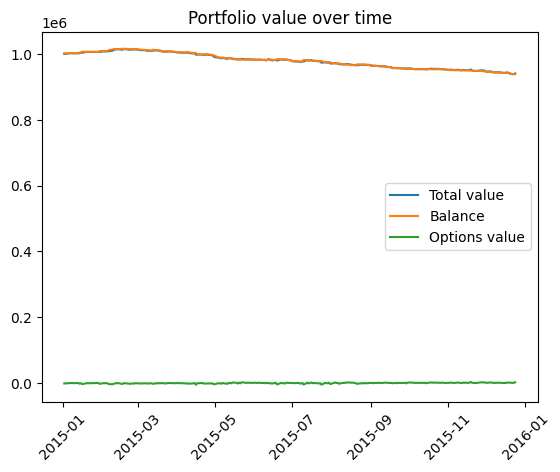

In [27]:
plot(df)

In [29]:
import numpy as np

# Calculate the sharpe ratio of the strategy using the daily returns and using df["R"] as the annualised risk-free rate
def sharpe_ratio(df):
    df["Daily_returns"] = df["Total_value"].pct_change()
    sharpe_ratio = np.sqrt(252) * ((df["Daily_returns"].mean() - (df["R"]/252).mean()) / df["Daily_returns"].std())
    return sharpe_ratio


# Calculate max drawdown
def max_drawdown(df):
    df["Drawdown"] = df["Total_value"] / df["Total_value"].cummax() - 1
    max_drawdown = df["Drawdown"].min()
    return max_drawdown


Sharpe ratio -0.12025924048304085
Max drawdown -0.07511953990870046


### Finding best thresholds

In [30]:
# Test many conbinations of sell and buy thresholds to find the one that gives the highest Sharpe ratio
def find_best_thresholds(df, starting_balance):
    best_sharpe = -100
    best_sell = 0
    best_buy = 0
    for sell in range(5, 25, 5):
        for buy in range(5, 25, 5):
            df = df_read.copy()
            buy_signal, sell_signal = generate_buy_sell_signals(df, buy, sell)
            df = trader(df, buy_signal, sell_signal, starting_balance)
            df = calculate_options_value(df)
            sharpe = sharpe_ratio(df)
            # Print and plot the results
            print("Buy threshold", buy, "Sell threshold", sell, "Sharpe ratio", sharpe)
            print("Starting balance", starting_balance, "Ending balance", df['Balance'].iloc[-1])
            print("Anualiased return", (df['Balance'].iloc[-1] / starting_balance - 1) * 252 / len(df))
            print("Sharpe: ", sharpe)
            plot(df)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_sell = sell
                best_buy = buy
    return best_sharpe, best_sell, best_buy

best_sharpe, best_sell, best_buy = find_best_thresholds(df_read, starting_balance)
print("Best Sharpe ratio", best_sharpe, "Best sell threshold", best_sell, "Best buy threshold", best_buy)